## INSH2120 - Final Project

**Group 7**

**Forrest Meng, Garrett Michiels, Timothy Mitchell, Gabriel Peter, Daniel Pickett**
<hr>

## <center>The Relationship between Bars and Colleges in Boston and Alcohol-Related Crimes </center>

### Introduction
We set out to determine if there is a relationship between areas containing bars and colleges and specific alcohol related crimes such as underage liquor violations. Identifying if certain areas are more prone to these crimes could help the city of Boston understand the issue and put in plans to reduce these crimes. Our process starts by looking into criminology to understand some reasons why crimes occur when applied to our question. Then we download various datasets from [data.boston.gov](https://data.boston.gov/) including crime reports, liquor licenses, and location of colleges to use for analysis. Finally, we create various visualizations and analyze the results. In the end we found it difficult to find a correlation for our research question. It's likely that until more data is available from the city, it's unlikely that the relationship we set out to find can be proven significant.

#### Outline
1. [Background](#1)
2. [Read and Filter Data](#2)
3. [Spatial Joins / Aggregation](#3)
4. [Visualizations](#4)
5. [Analysis](#5)
6. [Future Work](#6)


<a id='1'></a>
## 1. Background
### Motivation

“In 2019, almost 2 out of 100 adolescents ages 12 to 13 reported drinking alcohol in the past month and fewer than 1 in 100 engaged in binge drinking. Among respondents ages 16 to 17, fewer than 1 in 5 reported drinking and about 1 in 10 reported binge drinking.5 It is important to implement prevention strategies during early adolescence to prevent this escalation.” - NIAAA<sup>1</sup>

Results:
- Increased death,
- Increased Injury
- Increases the risk of physical and sexual assault
- Interferes with brain development
- Future Alcoholism

1. “Underage Drinking.” National Institute on Alcohol Abuse and Alcoholism. U.S. Department of Health and Human Services. Accessed April 21, 2021. https://www.niaaa.nih.gov/publications/brochures-and-fact-sheets/underage-drinking. 

### Criminology Background

<img src="data/activity_theory.png" align="right" alt="Routine Activity Theory Venn Diagram" style="width:200px;">

Crime occurs when three elements converge:

- A motivated offender
- A suitable target
- The absence of a capable guardian



Cohen and Felson (1979)<sup>2</sup>

2. Smith, Clifton L, and David J Brooks. “Routine Activity Theory.” Science Direct. Accessed April 21, 2021. https://www.sciencedirect.com/topics/computer-science/routine-activity-theory. 

### Routine Activity Theory For Our Research Question

We will focus on two of the mentioned elements: motivated offenders and suitable targets.

With regards to alcohol related crimes, we view the <b>suitable target</b> as a place where a motivated offender can purchase or consume heavy amounts of alcohol (this could be a <b>bar/restaurant/liquor store</b>).

A specific group of <b>motivated offenders</b> that we can attempt to track is <b>college students</b>.

### Research Question

We will identify any correlation between the number of alcohol-related crimes and the number of bars at a neighborhood level in Boston.

We will work with our data to clean it and format it to be used for statistical analysis and visualization.
- Create heat maps at neighborhood level showing both alcohol-related crime and number of bars
- Overlay location of colleges on top


<a id='2'></a>
## 2. Read and Filter Data

### Imports

For this project we use the pandas, geopandas, and matplotlib modules.

In [460]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Crime Dataset

From [data.boston.gov](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system), we downloaded and read in the individual CSV for the crime incident reports from years 2015-2018. 2012-2015 is also available, but the system for the offense codes of crimes changed after this data was collected. We decided not to waste effort translating the old codes to the new codes, especially since the older data contained only about 10% of the records that the new data has. Additionally, not only were columns named differently after 2015, but the type of data collected and collection techniques also varies.

Unfortunately, we are unable to use more recent data from 2019, 2020, and 2021 as was has been removed from the city of Boston website and pending review at the time of working on this project.

**Boston.gov has re-added the 2019 to 2021 data which we now include in our final report.**

In [461]:
crime_2015 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2016 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2017 = pd.read_csv('data/crime-incident-reports-2017.csv')
crime_2018 = pd.read_csv('data/crime-incident-reports-2018.csv')
crime_2019 = pd.read_csv('data/crime-incident-reports-2019.csv')
crime_2020 = pd.read_csv('data/crime-incident-reports-2020.csv')
crime_2021 = pd.read_csv('data/crime-incident-reports-2021.csv')

/Users/daniel/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We appended all the individual files from each year into one DataFrame, then selected the columns of interest. Namely, OFFENSE_CODE, OFFENSE_DESCRIPTION, YEAR, and Lat/Long.

In [462]:
crime = pd.DataFrame()
crime=crime.append(crime_2015, ignore_index=True)
crime=crime.append(crime_2016, ignore_index=True)
crime=crime.append(crime_2017, ignore_index=True)
crime=crime.append(crime_2018, ignore_index=True)
crime=crime.append(crime_2019, ignore_index=True)
crime=crime.append(crime_2020, ignore_index=True)
crime=crime.append(crime_2021, ignore_index=True)
crime=crime[['OFFENSE_CODE', 'OFFENSE_DESCRIPTION', 'YEAR', 'Lat', 'Long']]

### Liquor Licenses Dataset

Again from [data.boston.gov](https://data.boston.gov/dataset/liquor-licenses), we downloaded and read the CSV containing info about liquor licenses in Boston. 

We select only the license ID, the issuing date, the type of license, the status of the license ('Active', etc.), the establishment name, the GPSX and GPSY coordinates, and the capacity.

In [463]:
alc = pd.read_csv('data/blb_section_12_alcohol.csv')
alc=alc[['license_num', 'issued', 'license_type', 'status', 'dba_name', 'gpsx', 'gpsy', 'capacity']]
alc.head()

,license_num,issued,license_type,status,dba_name,gpsx,gpsy,capacity
0,LB-418523,2020-07-30,Retail Malt Wine,Active,7-Eleven,772278.999995,2.951600e+06,0.0
1,LB-427987,2020-07-30,Retail Malt Wine,Active,"The Daily Market, LLC",776838.376864,2.939016e+06,0.0
2,LB-423824,2020-05-19,Retail Malt Wine,Active,Verc Allston Gulf,756044.793953,2.957524e+06,0.0
3,LB-410009,2020-03-04,CV7 All Alc. Airp.,Active,Wahlburgers,0.000000,0.000000e+00,100.0
4,LB-423834,2020-02-20,BYOB Bring Your Own Bottle,Active,Food For Thought Test Kitchen,786350.973004,2.964777e+06,40.0


### Colleges Dataset

We read in the colleges from the CSV, and filter only the name of the college as well as the Lat/Long and the number of students.

The number of students columns seems fairly unreliable for us to work with. A significant percentage of this column contains the value 0 even for significantly large universities. Additionally after researching student populations of 2015 which is the year our other data sets begin, the numbers are less, meaning this data is likely outdated. We can however still reliably use the coordinates.

In [464]:
colleges = pd.read_csv('data/Colleges_and_Universities.csv')
colleges = colleges[['Name', 'Latitude', 'Longitude', 'NumStudent']]
colleges.head()

,Name,Latitude,Longitude,NumStudent
0,Massachusetts General Hospital Dietetic Intern...,42.362591,-71.070141,10
1,Suffolk University,42.358905,-71.061948,9148
2,Benjamin Franklin Institute of Technology,42.346103,-71.070186,594
3,Bunker Hill Community College,42.375117,-71.069572,11009
4,MGH Institute of Health Professions,42.374917,-71.053972,900


### Neighborhood GeoJSON File

We imported the geoJSON file for Boston neighborhoods that we downloaded from data.boston.gov. We also cast the Neighborhood_ID field from and Object to an int.

We chose to use neighborhood-level analysis as opposed to tract level because after observing our filtered data (seen below), we realized that the amount of either bars or crimes for many census tracts was too low. We wanted to show more significant variation between larger areas of Boston.

In [465]:
nb = gpd.read_file("data/Boston_Neighborhoods.geojson")
nb = nb.astype({'Neighborhood_ID': 'int64'})
nb.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ..."
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335..."
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337..."
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06663 42.348..."


### Filtering the crime data

We only want to look at crimes that are explicitly related to alcohol. The offense codes that we used were 2201, 2101, and 2646, which are respectively 'Liquor - Involving Minors', 'Operating Under the Influence of Alcohol', and 'Liquor - Drinking in Public'.

We them removed any rows that had a null value for either Lat or Long.

In [466]:
off_codes = [2201, 2101, 2646]
crime = crime.loc[crime['OFFENSE_CODE'].isin(off_codes)]
crime = crime[crime[['Lat', 'Long']].notnull().all(1)]
crime.head()

,OFFENSE_CODE,OFFENSE_DESCRIPTION,YEAR,Lat,Long
1066,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.282319,-71.099614
1771,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.300270,-71.049671
2059,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.301415,-71.062878
2075,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.385047,-71.013741
2091,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.374686,-71.038931


### Filtering liquor licenses data

We wanted to focus specifically on bars or similar establishments where patrons would engage in drinking at the establishment as opposed to just purchasing the alcohol for later use. There are many types of liquor licenses, but we found that in order to remove places such as gas stations or liquor stores and only focus on sit-down restaurants and bars, we could efficiently select only those rows where the license type contained the string 'All Alc.'

We then remove any rows that had a null value for license year.

In [467]:
alc = alc.loc[alc['license_type'].str.contains('All Alc.')]
alc = alc.loc[alc['status'].str.contains('Active')]
alc = alc[alc[['issued', 'license_type']].notnull().all(1)]
alc.head()

,license_num,issued,license_type,status,dba_name,gpsx,gpsy,capacity
3,LB-410009,2020-03-04,CV7 All Alc. Airp.,Active,Wahlburgers,0.000000,0.000000e+00,100.0
6,LB-414876,2020-02-11,CV7 All Alc. Airp.,Active,B Good Burger,785396.803968,2.958230e+06,32.0
8,LB-419273,2020-01-07,CV7 All Alc.,Active,KJ's,777349.961472,2.932091e+06,10000.0
9,LB-408105,2019-12-19,CV7 All Alc. Airp.,Active,Mija Cantina,0.000000,0.000000e+00,125.0
10,LB-400460,2019-11-27,CV7 All Alc. Airp.,Active,Santarpio's Pizza,0.000000,0.000000e+00,68.0


The licenses data starts with 1434 rows. After filtering only 'All Alc.' licenses there are 943 rows. After removing inactive and licenses with null issue data and license types there are 939 rows. We did filter a large amount but are still left with a fairly large number of bars/restaurants/stores for our analysis.

<a id='3'></a>
## 3. Spatial Joins / Aggregation

### Spatial Joins

The next four code cells are dedicated to converting the Lat/Long columns from each dataset into a Neighborhood_ID that will be used for aggregation and mapping.

In [468]:
crime_gdf = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.Long, crime.Lat))
crime_gdf = crime_gdf.set_crs("EPSG:4326")
crime_gdf = gpd.sjoin(crime_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
crime = pd.DataFrame(crime_gdf.drop(columns=['geometry', 'index_right']))
crime = crime[crime['Neighborhood_ID'].notna()]
crime = crime.astype({'Neighborhood_ID': 'int64'})

In [469]:
college_gdf = gpd.GeoDataFrame(colleges, geometry=gpd.points_from_xy(colleges.Longitude, colleges.Latitude))
college_gdf = college_gdf.set_crs("EPSG:4326")
college_gdf = gpd.sjoin(college_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
colleges = pd.DataFrame(college_gdf.drop(columns=['geometry', 'index_right']))
colleges = colleges[colleges[['Neighborhood_ID','NumStudent']].notnull().all(1)]
colleges = colleges.astype({'Neighborhood_ID': 'int64'})
colleges = colleges[colleges.Neighborhood_ID != 28]

#### Note on Liquor Licenses Dataset

The coords for the liquor dataset are in SPC form, and must be converted to Lat/Long. This was done using [an online tool](https://geodesy.noaa.gov/NCAT/). Instead of having null values, the initial coords were set to 0. When converted to Lat/Long, the value was under 35 (nowhere near Boston). We filtered out any rows with Lat/Long under 35.

In [472]:
alc_latlong = pd.read_csv('data/alc_coords.csv')
alc_latlong = alc_latlong.rename(columns={"ID":"license_num"})
alc_latlong
alc = pd.merge(alc, alc_latlong, on="license_num")
alc=alc[['license_type', 'license_num', 'status', 'dba_name', 'srcLat', 'srcLon']]
alc = alc[alc[['srcLat', 'srcLon']].notnull().all(1)]
alc = alc.loc[alc['srcLat'] > 35.0]

In [473]:
alc_gdf =gpd.GeoDataFrame(alc, geometry=gpd.points_from_xy(alc.srcLon, alc.srcLat))
alc_gdf = alc_gdf.set_crs("EPSG:4326")
alc_gdf = gpd.sjoin(alc_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
alc = pd.DataFrame(alc_gdf.drop(columns=['geometry', 'index_right']))
alc = alc[alc[['Neighborhood_ID']].notnull().all(1)]
alc = alc.astype({'Neighborhood_ID': 'int64'})

We can see after applying this conversion to the coordinates and applying the spatial join, we have a neighborhood id for each of our datasets.

In [474]:
crime.head()

,OFFENSE_CODE,OFFENSE_DESCRIPTION,YEAR,Lat,Long,Neighborhood_ID,Name
1066,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.282319,-71.099614,12,Mattapan
1771,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.300270,-71.049671,6,Dorchester
2059,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.301415,-71.062878,6,Dorchester
2075,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.385047,-71.013741,8,East Boston
2091,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.374686,-71.038931,8,East Boston


In [475]:
alc.head()

,license_type,license_num,status,dba_name,srcLat,srcLon,Neighborhood_ID,Name
1,CV7 All Alc. Airp.,LB-414876,Active,B Good Burger,42.364540,-71.021817,8,East Boston
2,CV7 All Alc.,LB-419273,Active,KJ's,42.292934,-71.052100,6,Dorchester
6,CV7 All Alc. Restrict.,LB-374985,Active,Bucktown Chicken & Fish,42.332230,-71.099860,13,Mission Hill
7,CV7 All Alc. Restrict.,LB-375393,Active,Totto Ramen,42.325376,-71.062824,6,Dorchester
10,CV7 All Alc. Restrict.,LB-400468,Active,Mariel,42.357508,-71.055848,7,Downtown


In [476]:
colleges.head()

,Name_left,Latitude,Longitude,NumStudent,Neighborhood_ID,Name_right
0,Massachusetts General Hospital Dietetic Intern...,42.362591,-71.070141,10,31,West End
1,Suffolk University,42.358905,-71.061948,9148,7,Downtown
2,Benjamin Franklin Institute of Technology,42.346103,-71.070186,594,32,South End
3,Bunker Hill Community College,42.375117,-71.069572,11009,4,Charlestown
4,MGH Institute of Health Professions,42.374917,-71.053972,900,4,Charlestown


### Aggregating

Now, we group the datasets by neighborhood with a count method.

In [477]:
bar_count = alc.groupby(by=['Neighborhood_ID']).count()['license_num']
bar_count = bar_count.rename('bar_count')
bar_count[:5]

Neighborhood_ID
2     95
4     18
6     69
7    155
8     33
Name: bar_count, dtype: int64

Note: crime_count is not counting offenses from outside of Boston

In [478]:
crime_count = crime.groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count = crime_count.rename('crime_count')
crime_count[:5]

Neighborhood_ID
2     65
4     13
6    224
7     71
8     69
Name: crime_count, dtype: int64

In addition to counting all crimes, we also will count each individual type of crime in each neighborhood.
- 2201 = Liquor Involving Minors
- 2101 = Operating Under the Influence of Alcohol
- 2646 = Drinking in Public

In [479]:
crime_count_minor = crime[crime['OFFENSE_CODE'] == 2201].groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count_minor = crime_count_minor.rename('minor_count')

crime_count_dui   = crime[crime['OFFENSE_CODE'] == 2101].groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count_dui   = crime_count_dui.rename('dui_count')

crime_count_dip   = crime[crime['OFFENSE_CODE'] == 2646].groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count_dip   = crime_count_dip.rename('public_drink_count')

In [497]:
college_count = colleges.groupby(by=['Neighborhood_ID']).count()['Name_left']
college_count = college_count.rename('college_count')
college_count[:5]

Neighborhood_ID
2     6
4     3
6     2
7     6
10    1
Name: college_count, dtype: int64

Student count counts the total student population by summing the number of students at each college within a neighbhorhood.

In [498]:
student_count = colleges.groupby(by=['Neighborhood_ID']).sum()['NumStudent']
student_count = student_count.rename('student_count')
student_count[:5]

Neighborhood_ID
2      4400
4     12528
6     15581
7     16387
10      147
Name: student_count, dtype: int64

... and merge them into one dataframe.

In [499]:
crime_col = {'crime':crime_count}
crime_df = pd.DataFrame(crime_col)

crime_col2 = {'minor_crimes':crime_count_minor}
crime_df2 = pd.DataFrame(crime_col2)

crime_col3 = {'dui_crimes':crime_count_dui}
crime_df3 = pd.DataFrame(crime_col3)

crime_col4 = {'drinking_public_crimes':crime_count_dip}
crime_df4 = pd.DataFrame(crime_col4)

bar_col = {'bars':bar_count}
bars_df = pd.DataFrame(bar_col)

college_col = {'colleges':college_count}
college_df = pd.DataFrame(college_col)

student_col = {'students':student_count}
student_df = pd.DataFrame(student_col)

Our combined_df contains the outer join of bars, colleges, total crime, and each seperate type of crime. Since many neighborhoods do not have colleges,
by inner joining with the colleges our maps will show many neighborhoods as missing. Therefore we will perform an outer join to ensure neighborhoods are not removed, as we want our maps to represent all of Boston. We can assume a missing or NaN value after the join means a count of 0.

In [500]:
combined_df = crime_df.join(bars_df, how='outer', sort=False)
combined_df = combined_df.join(college_df, how='outer', sort=False)
combined_df = combined_df.join(student_df, how='outer', sort=False)
combined_df = combined_df.join(crime_df2, how='outer', sort=False)
combined_df = combined_df.join(crime_df3, how='outer', sort=False)
combined_df = combined_df.join(crime_df4, how='outer', sort=False)
combined_df = combined_df.fillna(0)
combined_df

,crime,bars,colleges,students,minor_crimes,dui_crimes,drinking_public_crimes
Neighborhood_ID,,,,,,,
2,65,95,6.0,4400.0,0.0,21,44.0
4,13,18,3.0,12528.0,0.0,13,0.0
6,224,69,2.0,15581.0,0.0,145,79.0
7,71,155,6.0,16387.0,0.0,19,52.0
8,69,33,0.0,0.0,0.0,57,12.0
10,25,10,1.0,147.0,0.0,23,2.0
11,42,19,0.0,0.0,0.0,25,17.0
12,91,8,0.0,0.0,0.0,29,62.0
13,55,8,2.0,4292.0,0.0,7,48.0


**A note on liquor involving minors (minor_crimes col)**

As it can be seen from the dataframe above, when we count specifically crimes with the code 2201, which is noted in boston criminal offense code documentation as 'Liquor involving minors', we see there are no records for this crime. When we first imported and analyzed the data this was not the case. There were many crimes falling under this category for various neighborhoods. Until recently the datasets have been updated by the city. They note the data sets have been updated with "the exclusion of data that falls under MGL ch.41 s.98f". 

Looking at this section 98f from malegislature.gov https://malegislature.gov/laws/generallaws/parti/titlevii/chapter41/section98f it can be seen that

> the following entries shall be kept in a separate log and shall not be a public record.

(iv) any entry concerning the arrest of a person who has not yet reached 18 years of age. It could be the case that these specific crime code has been removed from the data since it is reporting on incidents of underage people and could not comply with the law above. Since we don't have access the data we can't include it our report and must focus in our visualizations and analysis on specifically dui and drinking in public.

<a id='4'></a>
## 4. Visualizations

From here, we just need to translate this data into maps for clear visualization.

We have a map each for the crimes and bars datasets, and on both maps we overlay the locations of colleges in Boston as red dots.

In [501]:
college_geo = gpd.points_from_xy(colleges.Longitude, colleges.Latitude)
c_geo_df = gpd.GeoDataFrame(geometry = college_geo)

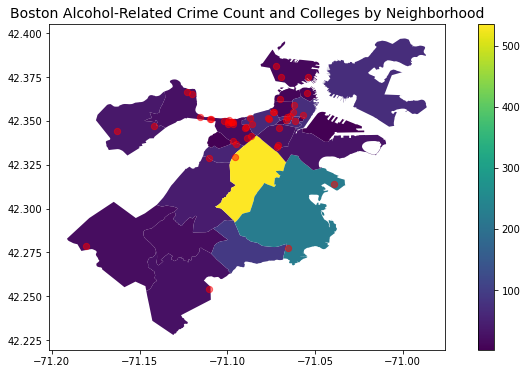

In [518]:
fig,ax = plt.subplots(figsize = (12,6))
crime_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
crime_map.plot(ax = ax, column = 'crime', legend=True)
g = c_geo_df.plot(ax=ax, markersize = 40, color = 'red', alpha=0.5)
plt.title('Boston Alcohol-Related Crime Count and Colleges by Neighborhood', fontsize = 14)
plt.show()

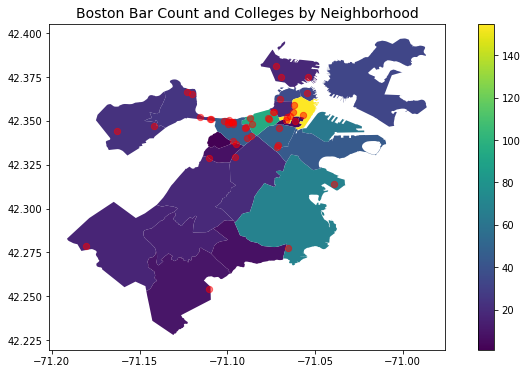

In [519]:
fig,ax = plt.subplots(figsize = (12,6))
bar_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
bar_map.plot(ax=ax, column = 'bars', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 40, color = 'red', alpha=0.5)
plt.title('Boston Bar Count and Colleges by Neighborhood', fontsize = 14)
plt.show()

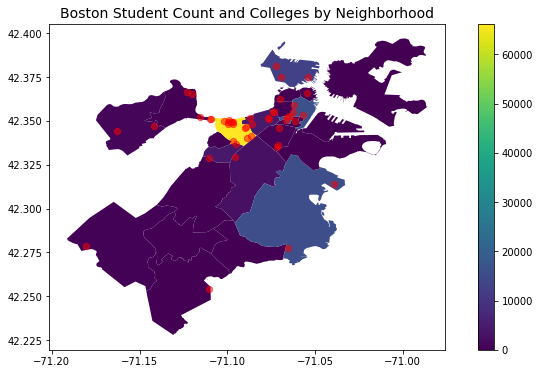

In [520]:
fig,ax = plt.subplots(figsize = (12,6))
bar_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
bar_map.plot(ax=ax, column = 'students', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 40, color = 'red', alpha=0.5)
plt.title('Boston Student Count and Colleges by Neighborhood', fontsize = 14)
plt.show()

<a id='5'></a>
## 5. Analysis

<Figure size 432x288 with 0 Axes>

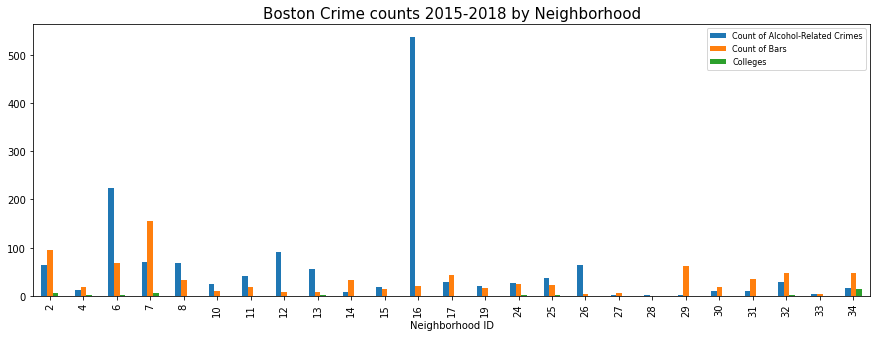

In [529]:
fig = plt.figure()
ax = combined_df[['crime', 'bars', 'colleges']].plot.bar(legend=True, figsize=(15,5), fontsize=10)
plt.title('Boston Crime counts 2015-2018 by Neighborhood', fontsize = 15)
plt.legend(["Count of Alcohol-Related Crimes", "Count of Bars", 'Colleges'], prop={"size":8})
plt.xlabel('Neighborhood ID', fontsize=10)
plt.show()

It's clear from the bar chart above that neighborhood 16 (Roxbury) has a much higher alcohol crime rate than any other of the neighborhoods within Boston. However, Roxbury has relatively few bars. This is really showing that there's many more factors in play contributing to crime than the presense of an establishment selling alcohol. Using the count of bars and colleges alone it is difficult to find any relationship. 

In [532]:
correlation = combined_df[['crime', 'bars','colleges']].corr()
correlation

,crime,bars,colleges
crime,1.000000,0.074499,-0.030558
bars,0.074499,1.000000,0.460951
colleges,-0.030558,0.460951,1.000000


Looking at the correlation of all crime counts and all bars counts shows there is no correlation as the coefficent is near 0. There is a moderate relationship between the number of colleges and the number of bars, which makes sense as most of the colleges in Boston are in more densely populated areas with more restaurants and stores. Of any of our visualizations this chart is the most telling. It's clear from the values that the correlation we were looking for, or expected at the start, is not present in the data.

<a id='6'></a>
## 6. Future Work

To research our question we have made the most out of the data and reporting that was available. If the city of Boston had increases the priority of reporting and labeling certain crimes such as those involving minors we suspect a stronger correlation could be found by looking specifically at crimes involving minors around college areas. Since this reporting code seems to not be used it's very challenging to truly know the answer to our research question. If more data becomes available in future years this is a project that could be built onto. However, we have given our best at the analysis with the data that is given. The same can be said for the data on liquor licenses. If we could know more specifically which types of establishments might contribute the most to certain crimes that could be helpful for the city but would require more data.

One future aspect that could be improved for future works is working more with the descriptions of the business. Through text analysis we could determine if the description of an establishment can be used to learn more about what type of business it is. This would require some more advanced techiques, since this description does not followed a specific format. Another feature that could be added, specifically for driving under the influence, is an average commute time or average number of cars per household. Some metric to account for areas outside the city having a higher number of vehicles. This might require finding and importing another data set.